<h2>TEXT CLUSTERING</h2>
<b>Arma grupos (clusters) de textos por similitud (temas) usando librerías de NLP Y Machine Learning</b> <br>
Entrada csv: conversacion_id,texto_preprocesado <br>
Salida de 2 archivos csv: <br>
- 1 con los clusters: conversacion_id,texto_preprocesado,cluster <br>
- el otro con bigramas y trigramas por cluster: cluster,bigrams,trigrams

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# SETEO DE VARIABLES

# archivos
archivo_csv_importar = 'cluster_8_sub_0.csv'
titulo_columna = 'texto_preprocesado' #'columna_concatenada'
id_columna = 'conversacion_id'
titulo_cluster_archivo_salida = 'sub_cluster_new'
grabar_archivo = True
archivo_csv_exportar = 'cluster_8_sub_0_export.csv'
archivo_csv_exportar_palabras = 'cluster_8_sub_0_top_words.csv'
file_path = '/content/drive/MyDrive/Colab Notebooks/' # para google colab
#file_path = 'data/' # para entorno local

#cant de clusters
k_clusters = 14

# '' default (ej: pagó), 's' stemmization (ej: pag_), 'l' lemmatization (ej: pagar)
forma_tokenizar = ''
if forma_tokenizar == 's':
    lem = False
    stemm = True
elif forma_tokenizar == 'l':
    lem = True
    stemm = False
else:
    lem = False
    stemm = False

# lista custom stopwords
con_stopwords = True
stopwords_agregar = {"a","eh","mirá","mira","hola","día","buen","Buen","Buenas","dia", "buenas","buenos","tardes", "noches","Bot","bot","Hola","xq","gracias","ok","dale",
                     "si","sí","hoy", "dias", "días", "hice", "q", "que", "buen dia", "buen día", "está", "buenos dias", "buenos días", "lunes", "por favor"
                     , "quiero", "quería", "queria", "necesito", "necesitaría", "necesitaria", "¡hola!", "¡hola", "bot!"}
stopwords_quitar = {'cual', 'cuando', 'donde','no'}

sinonimos = {'agente': 'representante', 'persona': 'representante', 'operador': 'representante', 'asesor': 'representante'
             , 'empleado': 'representante', 'humano': 'representante', 'alguien': 'representante', 'atención': 'representante'
             , 'máquina': 'representante', 'gerente': 'representante', 'asistente': 'representante', 'sector': 'representante'
             , 'abonar': 'pagar', 'saldar': 'pagar', 'pago': 'pagar'
             , 'monto': 'saldo', 'deuda': 'saldo', 'mes': 'saldo', 'debo': 'saldo', 'importe': 'saldo', 'costo': 'saldo'
             , 'adeudo': 'saldo', 'cuánto': 'saldo'
             , 'boleta': 'factura', 'boletas': 'factura', 'bolita': 'factura', 'papeleta': 'factura', 'abono': 'factura'
             , 'plan': 'factura', 'facturas': 'factura', 'facturación': 'factura'
             , 'consulta': 'consultar', 'conocer': 'consultar', 'saber': 'consultar', 'averiguar': 'consultar', 'ver': 'consultar'
             , 'preguntar': 'consultar', 'pregunta': 'consultar'
             , 'comunicar': 'hablar', 'pasar': 'hablar', 'atender': 'hablar', 'atienda': 'hablar', 'dame': 'hablar'
             , 'pásame': 'hablar', 'pasame': 'hablar'
             , 'quería': 'quiero', 'quisiera': 'quiero', 'necesito': 'quiero', 'necesitaría': 'quiero', 'gustaría': 'quiero'
             , 'error': 'problema', 'inconveniente': 'problema', 'suspendido': 'problema', 'restauración': 'problema'
             , 'vencido': 'vencida', 'vencimiento': 'vencida', 'vence': 'vencida'
             , 'debaja': 'baja', 'debajo': 'baja', 'quitar': 'baja', 'eliminar': 'baja', 'borrar': 'baja', 'borrarme': 'baja'
             , 'descuento': 'promoción', 'rebaja': 'promoción', 'bonificación': 'promoción', 'beneficio': 'promoción'
             , 'promo': 'promoción', 'barato': 'promoción'
             , 'bastante': 'aumento', 'caro': 'aumento', 'más': 'aumento', 'tanto': 'aumento', 'interés': 'aumento'
             , 'mucho': 'aumento', 'aumentó': 'aumento', 'incremento': 'aumento', 'incrementó': 'aumento'
             , 'hola': 'saludo', 'tardes': 'saludo', 'días': 'saludo', 'noches': 'saludo', 'buenas': 'saludo'
             , 'asunto': 'tema'
             , '.ar': 'homebanking', 'home banking': 'homebanking'}

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
# import random
from random import sample
import os
#, ibm_db, ibm_db_dbi as dbi
import operator
from collections import Counter
import string
from gensim.models.phrases import Phrases, Phraser
from IPython.display import Markdown, display, HTML

pd.set_option("display.max_rows", 600)
pd.set_option("display.max_columns", 500)
pd.set_option("max_colwidth", 400)

In [ ]:
#!python -m spacy download es_core_news_sm # ejecutar x 1ra vez y luego restartear el kernel, después dejarlo comentado
import spacy
from spacy.lang.es.stop_words import STOP_WORDS
nlp = spacy.load("es_core_news_sm", disable=['ner', 'parser', 'tagger'])

In [ ]:
# loguearse a cuenta Google: ejecutarlo una sola vez, después comentarlo
#from google.colab import drive
#drive.mount("/content/drive")

In [ ]:
dataset = pd.read_csv(file_path + archivo_csv_importar, encoding='utf8')

In [ ]:
dataset.shape

(1364, 3)

In [ ]:
# Función para filtrar filas que tienen texto vacío o texto numérico
def filtrar_filas(valor):
    return not (valor == '' or valor.isnumeric() or valor == 'Hola')


In [ ]:
# Only select the Product and Consumer complaint columns
col = [id_columna, titulo_columna]
dataset= dataset[col]

# Drop rows with missing labels
dataset.dropna(subset=[titulo_columna], inplace=True)


In [ ]:
# Aplicar filtro en la columna específica
dataset = dataset[dataset[titulo_columna].apply(filtrar_filas)]

In [ ]:
dataset.shape

(1364, 2)

In [ ]:
dataset.head()

,conversacion_id,texto_preprocesado
0,b7cb9be0-6d00-4eb1-a6a3-0d85e7a650ed,quiero pedir tarjeta nueva porq roto
1,e80dac38-b0ae-4c33-bfdf-23c62ad706e2,descto sircreb incorrecto
2,2bebc825-2160-4548-8de1-638baaa56dc7,porfavor
3,239fce68-f6d3-49da-bb2d-68ab8328cb14,confirmar tarjeta llegó sucursal
4,2dd369a4-0825-44af-bedf-519fd7363a97,quiero bloquear tarjera


In [ ]:
# Select only only these products
#dataset=dataset[dataset['Product'].isin(['Credit reporting', 'Debt collection', 'Mortgage', 'Credit card','Student loan','Bank account or service','Consumer Loan'])]

# Shuffel the dataset to make sure we get an equal distribution of the data before splitting into train and test sets
dataset = dataset.sample(frac=1)
dataset.head(10)

,conversacion_id,texto_preprocesado
575,ca39d18d-8f74-490e-922c-2122a40fbff1,dinero
248,65296090-bcb8-43c6-9d62-d01f39e53e33,duda apareció pagar mil parece solo pagar mil porqué cobra mil
757,bb6050f8-55a8-4b94-9148-b57aa4bcced2,necesito habilitar tarjeta master
270,ef141aa0-6faa-409b-a956-278dd7d948bf,hablar tema conozco débito ejecuto
459,4fe7aaf0-ad0c-46c9-a42d-8977a9a8840f,carta cliente actualizada dia
1046,63a0dc36-c2d2-4be2-b84a-16592553ad12,reclamos
222,86ed8f45-27e9-41ec-b45d-d67a8d2bbc27,cobran fondo
1030,722cfa9a-b724-482e-90dc-533ed38940c0,cancelar deuda
967,243d10f2-7b5d-42ae-aa09-74919be935d4,gustaría cobrar jubilación
855,4bdd2171-7844-4d49-8201-92fb13111bf9,creidot hipotecario


In [ ]:
dataset.shape

(1364, 2)

In [ ]:
# mantiene en otro dataframe el original
dataset_original = dataset.copy()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import nltk
from nltk.stem import *
#stemmer = PorterStemmer()
stemmer = SnowballStemmer("spanish")
import re
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

# Lets do some text cleanup
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
REMOVE_NUM = re.compile('[\d+]')
STOPWORDS = set(stopwords.words('spanish'))
if con_stopwords:
    STOPWORDS.update(stopwords_agregar) # extension stopwords para agregar
    for i in stopwords_quitar:
        STOPWORDS.discard(i)  # para quitar

# función traída de otra notebook
def normalize(s): #Vuela acentos
    replacements = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
    )
    for a, b in replacements:
        s = s.replace(a, b).replace(a.upper(), b.upper())
    return s

# función traída de otra notebook porque stemmer no convence
def simple_tokenizer(doc,stemm=stemm, lem=lem):
    doc = normalize(doc) #se pasa el texto a la función normalize
    tokenized_doc = ["" if t.isdigit() else t for t in doc.split()]  # se remueven los números
    tokenized_doc = [
        #token.lower() for token in tokenized_doc if token.lower() not in stopwords and token != ""
        token.lower() for token in tokenized_doc if token.lower() not in STOPWORDS and token != ""
    ] #se sacan las stopwords y ademas los tokens que quedan como "" ya que son números

    if stemm:
        tokenized_doc = [stemmer.stem(str(token)) for token in tokenized_doc] #sólo el stemming de los tokens

    if lem: #lemmatization
        tokenized_doc = " ".join(tokenized_doc)
        tokenized_doc = [x.lemma_ for x in nlp(tokenized_doc)]


    return tokenized_doc


def clean_text(text):
    """
    text: a string
    return: modified initial string
    """
    # lowercase text
    text = text.lower()

    # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = REPLACE_BY_SPACE_RE.sub(' ', text)

    # Remove the XXXX values
    text = text.replace('x', '')

    # Remove white space
    text = REMOVE_NUM.sub('', text)

    # Remove . ; ! ?
    text = REMOVE_NUM.sub('.', text)
    text = REMOVE_NUM.sub(';', text)
    text = REMOVE_NUM.sub(':', text)
    text = REMOVE_NUM.sub('!', text)
    text = REMOVE_NUM.sub('?', text)
    text = REMOVE_NUM.sub('¡', text)
    text = REMOVE_NUM.sub('¿', text)

    #  delete symbols which are in BAD_SYMBOLS_RE from text
    #text = BAD_SYMBOLS_RE.sub('', text)

    # delete stopwords from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)

    # removes any words composed of less than 2 or more than 21 letters
    text = ' '.join(word for word in text.split() if (len(word) >= 2 and len(word) <= 21))

    # Stemming the words
    #text = ' '.join([stemmer.stem(word) for word in text.split()])

    # Stemming the words
    if forma_tokenizar == 's':
        text = ' '.join([stemmer.stem(str(word)) for word in text.split()])
    elif forma_tokenizar == 'l': #lemmatization
        text = ' '.join(x.lemma_ for x in nlp(text))


    return text

# sinónimos
def synonym_tokenizer(text):
    words = text.split()
    tokens = [sinonimos.get(word, word) for word in words]
    return tokens


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
dataset[titulo_columna+'_token'] = dataset[titulo_columna].apply(clean_text)
#dataset[titulo_columna+'_token'] = dataset.apply(lambda x: simple_tokenizer(x[titulo_columna],lem=True), axis = 1) #se tokenizan los textos, opcion stem
# elimina tokens vacíos
dataset[titulo_columna+'_token'].replace('', np.nan, inplace=True)
dataset.dropna(subset=[titulo_columna+'_token'], inplace=True)

dataset.head(20)

,conversacion_id,texto_preprocesado,texto_preprocesado_token
575,ca39d18d-8f74-490e-922c-2122a40fbff1,dinero,dinero
248,65296090-bcb8-43c6-9d62-d01f39e53e33,duda apareció pagar mil parece solo pagar mil porqué cobra mil,duda apareció pagar mil parece solo pagar mil porqué cobra mil
757,bb6050f8-55a8-4b94-9148-b57aa4bcced2,necesito habilitar tarjeta master,habilitar tarjeta master
270,ef141aa0-6faa-409b-a956-278dd7d948bf,hablar tema conozco débito ejecuto,hablar tema conozco débito ejecuto
459,4fe7aaf0-ad0c-46c9-a42d-8977a9a8840f,carta cliente actualizada dia,carta cliente actualizada
1046,63a0dc36-c2d2-4be2-b84a-16592553ad12,reclamos,reclamos
222,86ed8f45-27e9-41ec-b45d-d67a8d2bbc27,cobran fondo,cobran fondo
1030,722cfa9a-b724-482e-90dc-533ed38940c0,cancelar deuda,cancelar deuda
967,243d10f2-7b5d-42ae-aa09-74919be935d4,gustaría cobrar jubilación,gustaría cobrar jubilación
855,4bdd2171-7844-4d49-8201-92fb13111bf9,creidot hipotecario,creidot hipotecario


### Run TF IDF Vectorizer on the text data

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [ ]:
#from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.cluster import KMeans

# Vectorización con TF-IDF
#vectorizer = TfidfVectorizer(stop_words=lst_stopwords)
#X = vectorizer.fit_transform(dataset["frase_derivacion"])

# Clustering con K-means
#kmeans = KMeans(n_clusters=25, random_state=0).fit(X)

# Resultados de los clusters
#print(kmeans.labels_)

In [ ]:
# Run TF IDF Vectorizer on the text data

lst_stopwords = list(STOPWORDS) # convierte formato set a list

# sublinear_df is set to True to use a logarithmic form for frequency
# min_df is the minimum numbers of documents a word must be present in to be kept
# norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1
# ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams
# stop_words is set to "english" to remove all common pronouns ("a", "the", ...) to reduce the number of noisy features
#.TfidfVectorizer(*, input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None
#, tokenizer=None, analyzer='word', stop_words=None, token_pattern='(?u)\b\w\w+\b', ngram_range=(1, 1), max_df=1.0, min_df=1
#, max_features=None, vocabulary=None, binary=False, dtype=<class 'numpy.float64'>, norm='l2', use_idf=True, smooth_idf=True
#, sublinear_tf=False)
vectorizer = TfidfVectorizer(sublinear_tf= True, min_df=10, norm='l2', ngram_range=(1, 2), encoding='utf-8'
                             , decode_error='ignore', strip_accents='ascii', lowercase=True
                             , tokenizer=synonym_tokenizer #función de sinónimos
                             , stop_words=lst_stopwords) #stop_words='spanish')
X_train_vc = vectorizer.fit_transform(dataset[titulo_columna+'_token'])

pd.DataFrame(X_train_vc.toarray(), columns=vectorizer.get_feature_names_out()).head()

acreditacion  acredito  adicional  ahora  ame  american  aparece  \
0           0.0       0.0        0.0    0.0  0.0       0.0      0.0   
1           0.0       0.0        0.0    0.0  0.0       0.0      0.0   
2           0.0       0.0        0.0    0.0  0.0       0.0      0.0   
3           0.0       0.0        0.0    0.0  0.0       0.0      0.0   
4           0.0       0.0        0.0    0.0  0.0       0.0      0.0   

   aplicacion  app  asi  atencion  atencion cliente  aun  ayer  ayuda  baja  \
0         0.0  0.0  0.0       0.0               0.0  0.0   0.0    0.0   0.0   
1         0.0  0.0  0.0       0.0               0.0  0.0   0.0    0.0   0.0   
2         0.0  0.0  0.0       0.0               0.0  0.0   0.0    0.0   0.0   
3         0.0  0.0  0.0       0.0               0.0  0.0   0.0    0.0   0.0   
4         0.0  0.0  0.0       0.0               0.0  0.0   0.0    0.0   0.0   

   banco  banco   banking  bloqueada  bloqueo  cajero  cancelar  cargo  \
0    0.0            0.0      0.0        0.0      0.0     0.0       0.0    0.0   
1    0.0            0.0      0.0        0.0      0.0     0.0       0.0    0.0   
2    0.0            0.0      0.0        0.0      0.0     0.0       0.0    0.0   
3    0.0            0.0      0.0        0.0      0.0     0.0       0.0    0.0   
4    0.0            0.0      0.0        0.0      0.0     0.0       0.0    0.0   

   cbu  celular  cheque  cierre  claves  cliente  cobrando  cobrar  cobraron  \
0  0.0      0.0     0.0     0.0     0.0      0.0       0.0     0.0       0.0   
1  0.0      0.0     0.0     0.0     0.0      0.0       0.0     0.0       0.0   
2  0.0      0.0     0.0     0.0     0.0      0.0       0.0     0.0       0.0   
3  0.0      0.0     0.0     0.0     0.0      0.0       0.0     0.0       0.0   
4  0.0      0.0     0.0     0.0     0.0      1.0       0.0     0.0       0.0   

   cobro  compra  compras  comprobante  comunique  constancia  constancia cbu  \
0    0.0     0.0      0.0          0.0        0.0         0.0             0.0   
1    0.0     0.0      0.0          0.0        0.0         0.0             0.0   
2    0.0     0.0      0.0          0.0        0.0         0.0             0.0   
3    0.0     0.0      0.0          0.0        0.0         0.0             0.0   
4    0.0     0.0      0.0          0.0        0.0         0.0             0.0   

   consultar  consumo  corresponde  credito  cuanto  cuenta  cuota  cuotas  \
0        0.0      0.0          0.0      0.0     0.0     0.0    0.0     0.0   
1        0.0      0.0          0.0      0.0     0.0     0.0    0.0     0.0   
2        0.0      0.0          0.0      0.0     0.0     0.0    0.0     0.0   
3        0.0      0.0          0.0      0.0     0.0     0.0    0.0     0.0   
4        0.0      0.0          0.0      0.0     0.0     0.0    0.0     0.0   

   datos  debin  debitaron    debito  debitos  deja  deposite  descargar  \
0    0.0    0.0        0.0  0.000000      0.0   0.0       0.0        0.0   
1    0.0    0.0        0.0  0.000000      0.0   0.0       0.0        0.0   
2    0.0    0.0        0.0  0.000000      0.0   0.0       0.0        0.0   
3    0.0    0.0        0.0  0.503814      0.0   0.0       0.0        0.0   
4    0.0    0.0        0.0  0.000000      0.0   0.0       0.0        0.0   

   descargar constancia  desconocimiento  desconozco  dice  dijeron  dinero  \
0                   0.0              0.0         0.0   0.0      0.0     1.0   
1                   0.0              0.0         0.0   0.0      0.0     0.0   
2                   0.0              0.0         0.0   0.0      0.0     0.0   
3                   0.0              0.0         0.0   0.0      0.0     0.0   
4                   0.0              0.0         0.0   0.0      0.0     0.0   

    do  domicilio  eactamente  efectivo  eminent  epress  estafa  favor  \
0  0.0        0.0         0.0       0.0      0.0     0.0     0.0    0.0   
1  0.0        0.0         0.0       0.0      0.0     0.0     0.0    0.0   
2  0.0        0.0         0

In [ ]:
dataset

,conversacion_id,texto_preprocesado,texto_preprocesado_token
575,ca39d18d-8f74-490e-922c-2122a40fbff1,dinero,dinero
248,65296090-bcb8-43c6-9d62-d01f39e53e33,duda apareció pagar mil parece solo pagar mil porqué cobra mil,duda apareció pagar mil parece solo pagar mil porqué cobra mil
757,bb6050f8-55a8-4b94-9148-b57aa4bcced2,necesito habilitar tarjeta master,habilitar tarjeta master
270,ef141aa0-6faa-409b-a956-278dd7d948bf,hablar tema conozco débito ejecuto,hablar tema conozco débito ejecuto
459,4fe7aaf0-ad0c-46c9-a42d-8977a9a8840f,carta cliente actualizada dia,carta cliente actualizada
...,...,...,...
549,39442f8a-648f-44b4-a867-f341e9bfa733,débitos automáticos,débitos automáticos
1289,08e1f28c-bcb7-46b1-9f4a-842af1671191,exactamente,eactamente
133,2ff93971-8d85-4827-bfe6-8dbe57270e51,hice procedumiento,procedumiento
510,a61c5e73-ced0-48ca-ad02-bb622bc8ce6c,n significa n,significa


In [ ]:
def grafico_Elbow(k_clusters, X_train):
  from sklearn.cluster import KMeans
  score = []
  for i in range(1,k_clusters + 1):
      kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=5,random_state=42)
      kmeans.fit(X_train)
      score.append(kmeans.inertia_)
  plt.plot(range(1,k_clusters + 1 ),score)
  plt.title('The Elbow Method')
  plt.xlabel('Number of clusters')
  plt.ylabel('Score')
  plt.savefig('elbow.png')
  plt.show()

# distortion score is the average of the squared distances from the cluster centers of the respective clusters
def grafico_Elbow_Distortion_Score(k_clusters, X_train):
  #install yellowbrick to vizualize the Elbow curve
  #!pip install yellowbrick
  from yellowbrick.cluster import KElbowVisualizer
  # Instantiate the clustering model and visualizer
  km = KMeans(random_state=42)
  visualizer = KElbowVisualizer(km, k=(2,k_clusters))
  visualizer.fit(X_train.toarray())        # Fit the data to the visualizer
  visualizer.show()

def grafico_PCA(k_clusters, X_train):
  from sklearn.decomposition import PCA
  sklearn_pca = PCA(n_components = 2)
  Y_sklearn = sklearn_pca.fit_transform(X_train.toarray())
  kmeans = KMeans(n_clusters=k_clusters, max_iter=600, algorithm = 'lloyd')
  fitted = kmeans.fit(Y_sklearn)
  prediction = kmeans.predict(Y_sklearn)
  plt.figure(figsize=(12, 6))
  plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=prediction, s=40, cmap='viridis', linewidths=5)
  centers = fitted.cluster_centers_
  plt.scatter(centers[:, 0], centers[:, 1],c='black', s=200, alpha=0.6)
  for i, center in enumerate(centers):
      plt.text(center[0], center[1], f"{i}", fontsize=8, ha='center', va='center', bbox=dict(fc='w', boxstyle='round,pad=1'))
  return prediction

def grafico_Silhouette_Score(X_train, max_clusters=k_clusters, filas_subplots=5):
  from yellowbrick.cluster import SilhouetteVisualizer
  fig, ax = plt.subplots(max_clusters//2, 2, figsize=(15,max_clusters))
  for i in range(max_clusters):
    if (i>=2): # no debe tomar ni 0 ni 1
      #Create KMeans instances for different number of clusters
      km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
      q, mod = divmod(i, 2)
      #Create SilhouetteVisualizer instance with KMeans instance
      #Fit the visualizer
      visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
      visualizer.fit(X_train.toarray())

def nube_palabras(y):
    from wordcloud import WordCloud
    combined_text = ' '.join(y.sum())
    wordcloud = (
        WordCloud(max_font_size=60,
                  max_words=40,
                  background_color="white",
                  collocations=False,
                  )
        .generate(combined_text)
    )
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    #plt.title(title)
    plt.axis("off")
    plt.show()


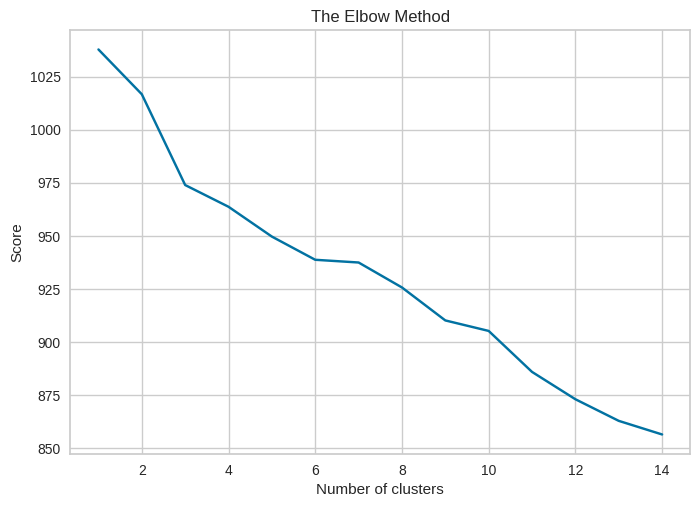

In [ ]:
grafico_Elbow(k_clusters, X_train_vc)

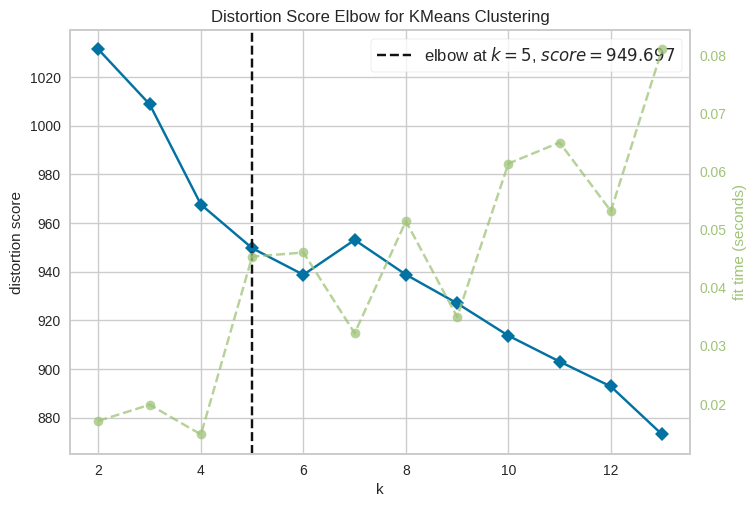

In [ ]:
grafico_Elbow_Distortion_Score(k_clusters, X_train_vc)

#### **Silhouette Score**

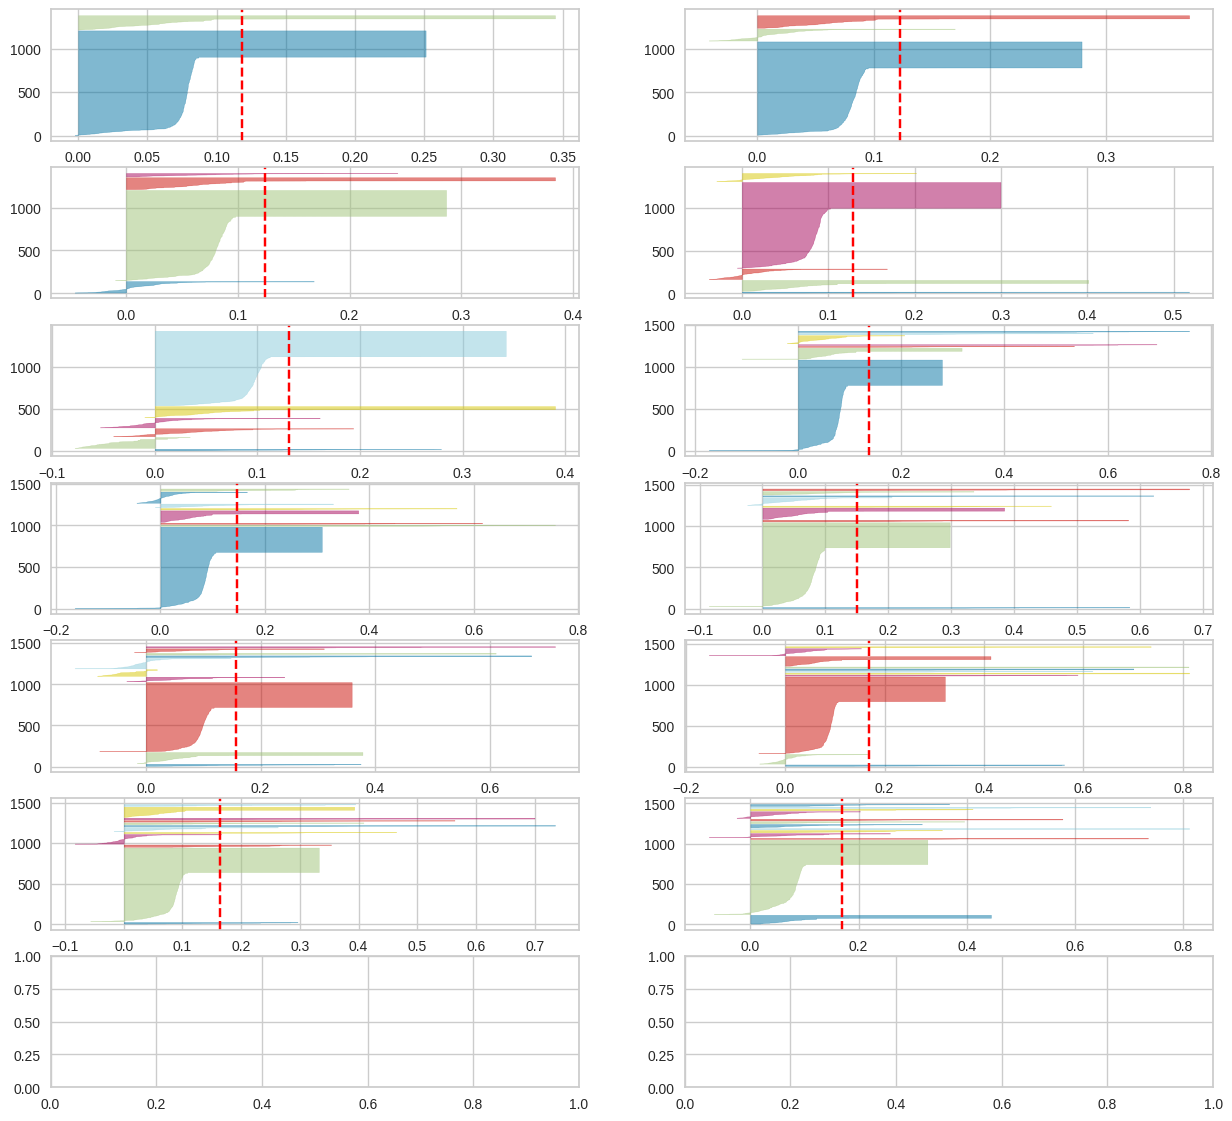

In [ ]:
grafico_Silhouette_Score(X_train_vc)

In [ ]:
model = KMeans(n_clusters=k_clusters, init='k-means++', n_init=10, max_iter=600, tol=0.000001, random_state=0)
model.fit(X_train_vc)

KMeans(max_iter=600, n_clusters=14, n_init=10, random_state=0, tol=1e-06)

### Do some predictions and display the results

In [ ]:
# First: for every document we get its corresponding cluster
clusters = model.predict(X_train_vc)

In [ ]:
dataset[titulo_cluster_archivo_salida] = clusters
# Convert the label (Product) to numeric using the pd factorize function
#dataset['category_id'] = dataset['Product'].factorize()[0]
dataset.head(20)

,conversacion_id,texto_preprocesado,texto_preprocesado_token,sub_cluster_new
575,ca39d18d-8f74-490e-922c-2122a40fbff1,dinero,dinero,0
248,65296090-bcb8-43c6-9d62-d01f39e53e33,duda apareció pagar mil parece solo pagar mil porqué cobra mil,duda apareció pagar mil parece solo pagar mil porqué cobra mil,0
757,bb6050f8-55a8-4b94-9148-b57aa4bcced2,necesito habilitar tarjeta master,habilitar tarjeta master,7
270,ef141aa0-6faa-409b-a956-278dd7d948bf,hablar tema conozco débito ejecuto,hablar tema conozco débito ejecuto,0
459,4fe7aaf0-ad0c-46c9-a42d-8977a9a8840f,carta cliente actualizada dia,carta cliente actualizada,0
1046,63a0dc36-c2d2-4be2-b84a-16592553ad12,reclamos,reclamos,0
222,86ed8f45-27e9-41ec-b45d-d67a8d2bbc27,cobran fondo,cobran fondo,11
1030,722cfa9a-b724-482e-90dc-533ed38940c0,cancelar deuda,cancelar deuda,2
967,243d10f2-7b5d-42ae-aa09-74919be935d4,gustaría cobrar jubilación,gustaría cobrar jubilación,0
855,4bdd2171-7844-4d49-8201-92fb13111bf9,creidot hipotecario,creidot hipotecario,0


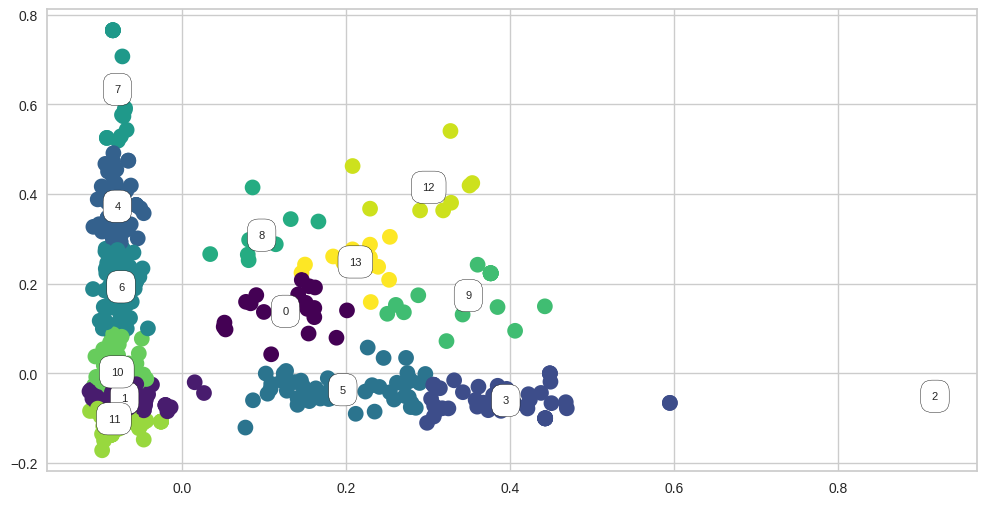

In [ ]:
prediction = grafico_PCA(k_clusters, X_train_vc)

### Top terms per cluster

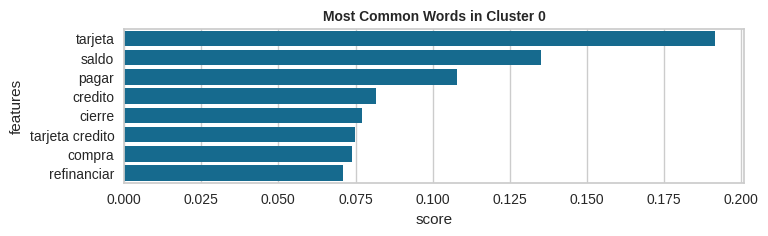

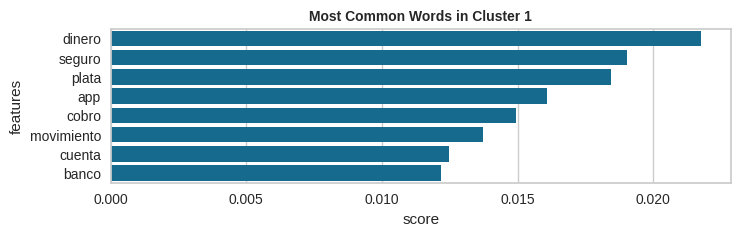

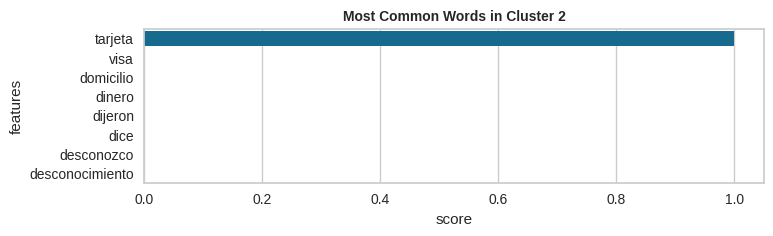

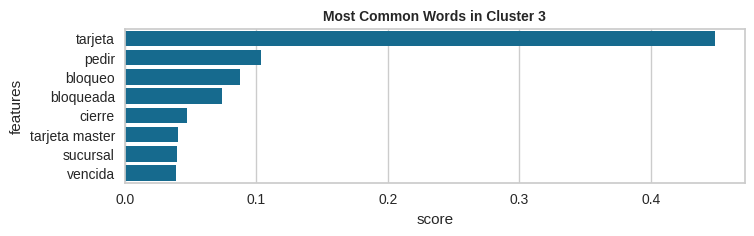

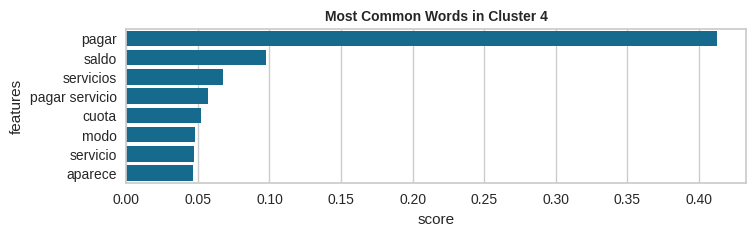

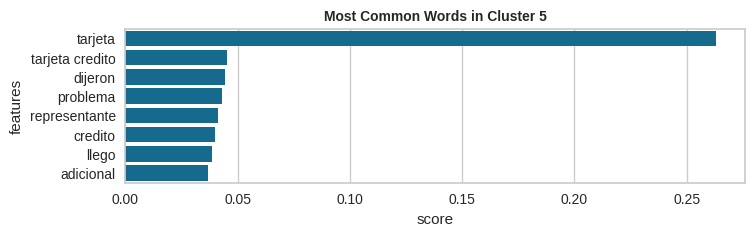

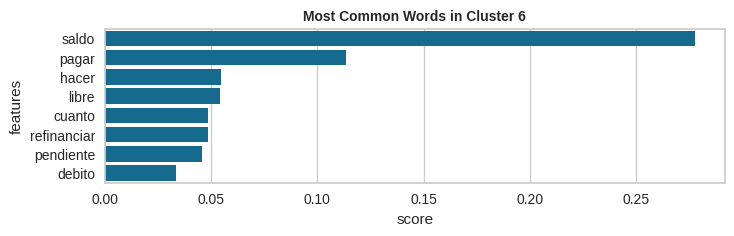

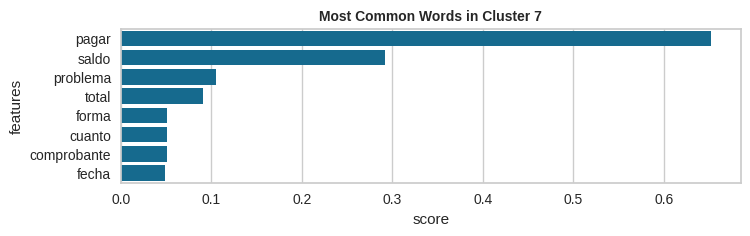

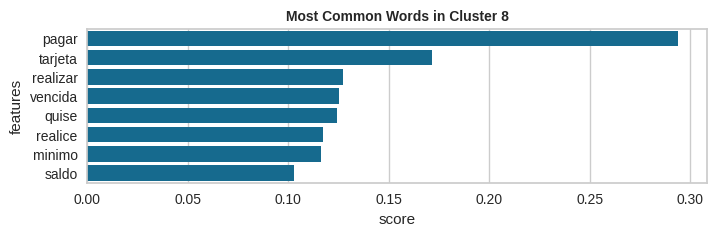

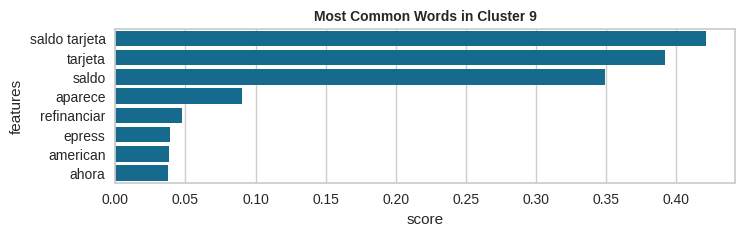

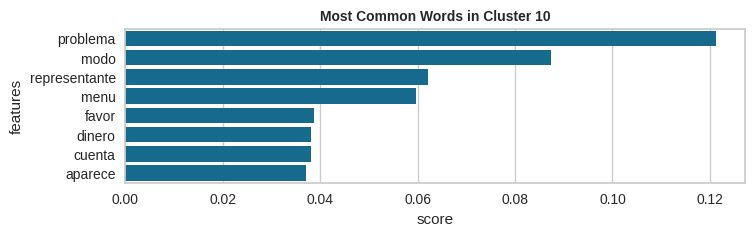

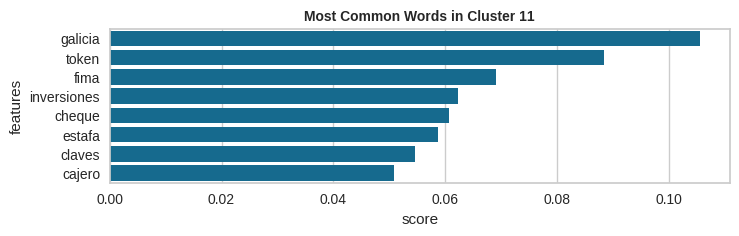

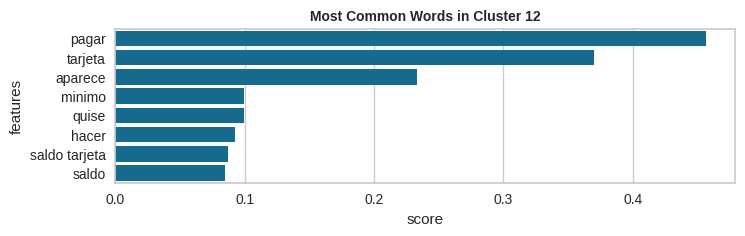

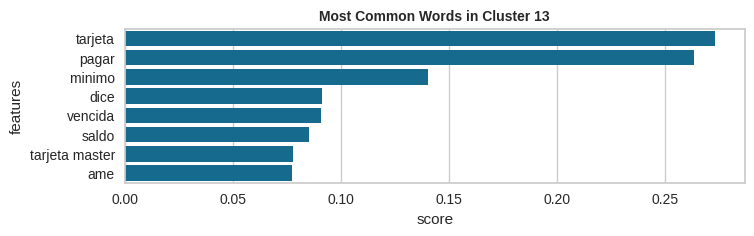

In [ ]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names_out()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs


def plotWords(dfs, n_feats):
    for i in range(0, len(dfs)):
        plt.figure(figsize=(8, 2))
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])

dfs = get_top_features_cluster(X_train_vc.toarray(), prediction, 8)
plotWords(dfs, 13)

### Centroides

In [ ]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]

terms = vectorizer.get_feature_names_out()
for i in range(k_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :10]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

Cluster 0: pagar dinero  problema representante app cuenta cobro seguro cajero
Cluster 1: menu cuotas pagar saldo tarjeta septiembre deposite dice desconozco desconocimiento
Cluster 2: saldo saldo tarjeta tarjeta pagar refinanciar libre total pendiente hacer banco
Cluster 3: plata llego transferi impuestos cajero debitaron tenia cuenta efectivo deposite
Cluster 4: cbu constancia cbu constancia descargar descargar constancia banco nombre funciona sucursal app
Cluster 5: claves menu bloqueo hacer problema  celular homebanking token datos
Cluster 6: modo pagar problema aplicacion ame credito reintegros informacion promociones nunca
Cluster 7: tarjeta pedir bloqueada tarjeta master master pagar sucursal vencida cierre adicional
Cluster 8: desconocimiento movimiento consumo oficial realizar tarjeta numero homebanking reclamo representante
Cluster 9: impuesto impuesto pais pais tarjeta peso cobrando compra cheque consumo ame
Cluster 10: refinanciacion hablar financiacion saldo viernes tarjet

In [ ]:
dataset.drop(titulo_columna+'_token', axis=1, inplace=True)
dataset.reset_index(drop=True, inplace=True)

In [ ]:
dataset.head(20)

,conversacion_id,texto_preprocesado,sub_cluster_new
0,ca39d18d-8f74-490e-922c-2122a40fbff1,dinero,0
1,65296090-bcb8-43c6-9d62-d01f39e53e33,duda apareció pagar mil parece solo pagar mil porqué cobra mil,0
2,bb6050f8-55a8-4b94-9148-b57aa4bcced2,necesito habilitar tarjeta master,7
3,ef141aa0-6faa-409b-a956-278dd7d948bf,hablar tema conozco débito ejecuto,0
4,4fe7aaf0-ad0c-46c9-a42d-8977a9a8840f,carta cliente actualizada dia,0
5,63a0dc36-c2d2-4be2-b84a-16592553ad12,reclamos,0
6,86ed8f45-27e9-41ec-b45d-d67a8d2bbc27,cobran fondo,11
7,722cfa9a-b724-482e-90dc-533ed38940c0,cancelar deuda,2
8,243d10f2-7b5d-42ae-aa09-74919be935d4,gustaría cobrar jubilación,0
9,4bdd2171-7844-4d49-8201-92fb13111bf9,creidot hipotecario,0


### Make some predictions

In [ ]:
cleaned_data = ["pago de tarjeta", #consultar visita
                "hablar con alguien del equipo"] # cancelar visita
cleaned_data = pd.DataFrame(cleaned_data, columns=[titulo_columna])
cleaned_data = cleaned_data[titulo_columna].apply(clean_text)
predicted = model.predict(vectorizer.transform(cleaned_data))
predicted

array([7, 0], dtype=int32)

In [ ]:
for i in range(k_clusters):
    print('\n\nCluster: '+ str(i)+'\n')
    print(dataset[dataset[titulo_cluster_archivo_salida]==i][titulo_columna])



Cluster: 0

0                                                                                                    dinero
1                                            duda apareció pagar mil parece solo pagar mil porqué cobra mil
3                                                                        hablar tema conozco débito ejecuto
4                                                                             carta cliente actualizada dia
5                                                                                                  reclamos
                                                       ...                                                 
1359                                                                                    débitos automáticos
1360                                                                                            exactamente
1361                                                                                     hice procedumiento
1362          

### **Nube de Palabras y Frecuencias**



Cluster: 0



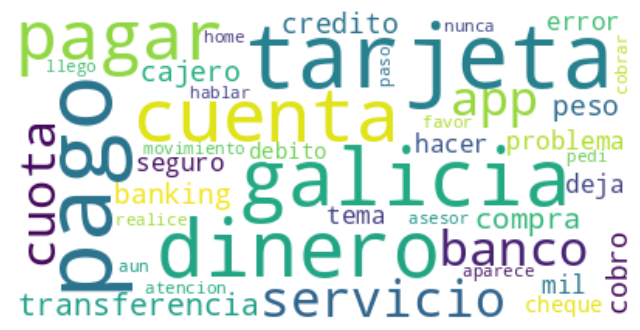



Cluster: 1



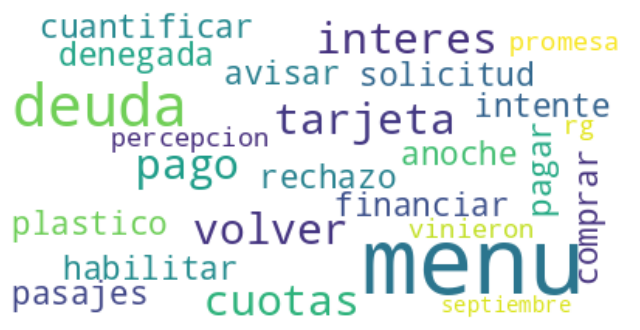



Cluster: 2



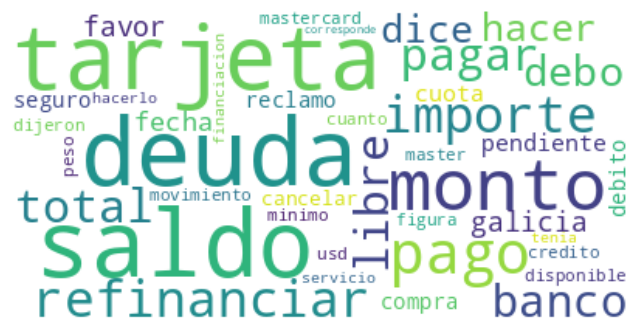



Cluster: 3



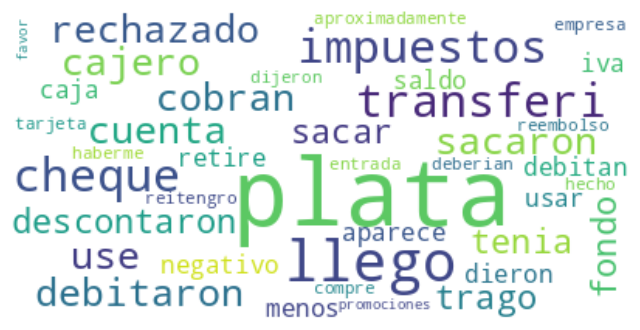



Cluster: 4



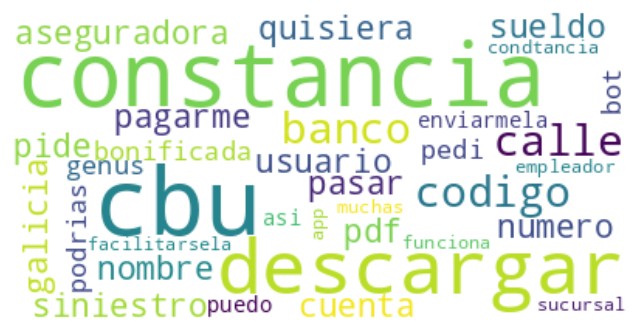



Cluster: 5



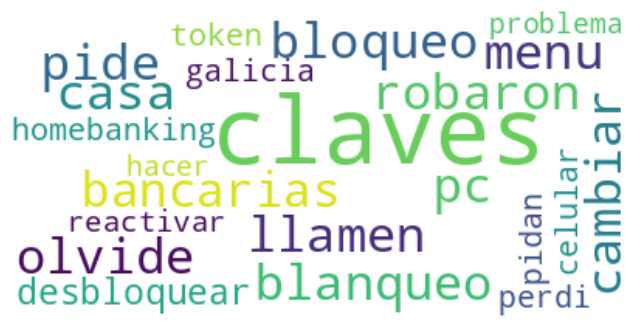



Cluster: 6



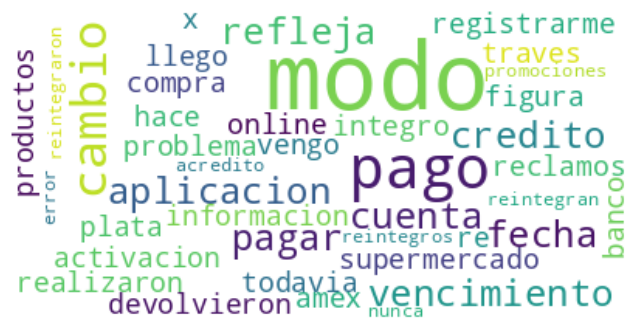



Cluster: 7



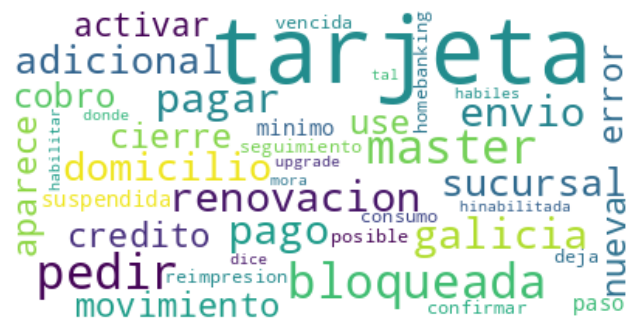



Cluster: 8



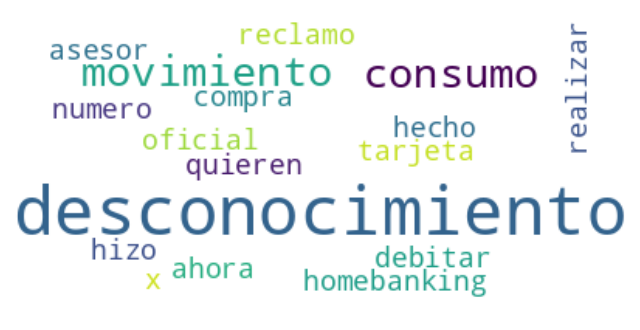



Cluster: 9



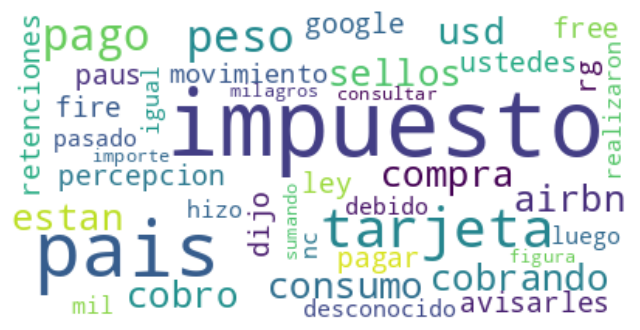



Cluster: 10



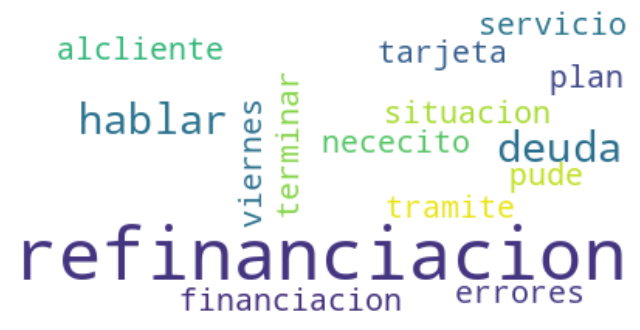



Cluster: 11



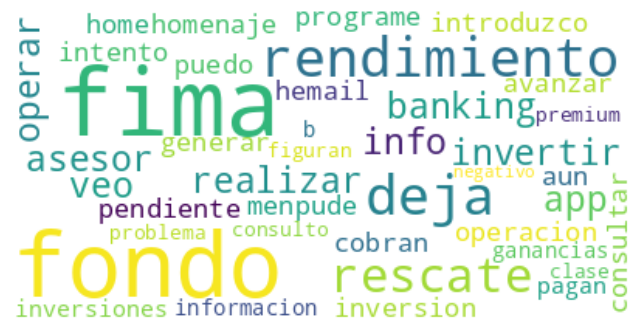



Cluster: 12



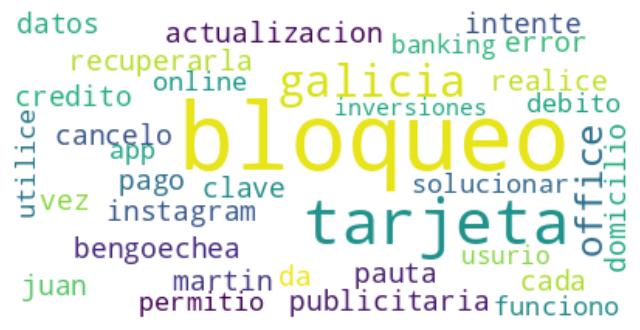



Cluster: 13



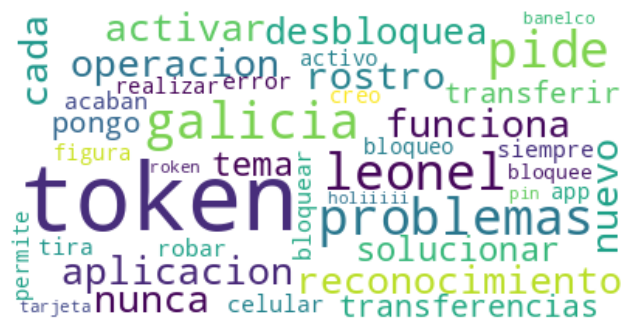

In [ ]:
def ngramas(df,gramas,columna=None,valor=None):
    df[f'{gramas}_gramas'] = df['tokens'].apply(lambda row: list(nltk.ngrams(row, gramas)))
    lista = []
    def desarmar(lista_):
        for conjuntos in set(lista_):
            lista.append(conjuntos)
    if columna != None:
        df[df[columna]==valor][f'{gramas}_gramas'].apply(lambda x: desarmar(x))
    else:
        df[f'{gramas}_gramas'].apply(lambda x: desarmar(x))
    frequence = nltk.FreqDist(lista)
    sort = sorted(frequence.items(), key=operator.itemgetter(1), reverse=True)
    return sort

# temp
#k_clusters = 2

import operator
from wordcloud import WordCloud
lst_cluster_words = []
#cant_gramas = 3
top_grams = 20

for i in range(k_clusters):
    print('\n\nCluster: '+ str(i)+'\n')
    dataset_cluster = dataset[dataset[titulo_cluster_archivo_salida]==i]
    dataset_nube = dataset_cluster.apply(lambda x: simple_tokenizer(x[titulo_columna]), axis = 1) #se tokenizan los textos
    nube_palabras(dataset_nube)
    # armar los trigramas
    dataset_cluster["tokens"] = dataset_cluster.apply(lambda x: simple_tokenizer(x[titulo_columna]), axis = 1) #se tokenizan los textos
    bigramas = ngramas(dataset_cluster,2)
    trigramas = ngramas(dataset_cluster,3)

    #text = ' '.join(dataset_nube.sum())  #esta celda es para medir la frecuencia de palabras
    ##text = ' '.join(gramas.sum()) # eliminar
    #count=WordCloud().process_text(text)
    #sort = sorted(count.items(), key=operator.itemgetter(1), reverse=True)
    #sort_filtered = [item for item in sort if item[1] > 2]
    #sort_top_20 = sorted(sort_filtered, key=lambda x: x[1], reverse=True)[:20]
    sort_top_bi = sorted(bigramas, key=lambda x: x[1], reverse=True)[:top_grams]
    sort_top_tri = sorted(trigramas, key=lambda x: x[1], reverse=True)[:top_grams]
    lst_cluster_words.append({
        'cluster': str(i),
        'bigrams': sort_top_bi,
        'trigrams': sort_top_tri
    })
    #print(bigramas)

In [ ]:
lst_cluster_words

[{'cluster': '0',
  'bigrams': [(('home', 'banking'), 16),
   (('tarjeta', 'credito'), 12),
   (('online', 'banking'), 11),
   (('banco', ''), 11),
   (('hablar', 'tema'), 9),
   (('atencion', 'cliente'), 9),
   (('cobrar', 'jubilacion'), 7),
   (('gustaria', 'cobrar'), 7),
   (('jubilacion', ''), 7),
   (('mercado', 'pago'), 7),
   (('servicio', 'eminent'), 6),
   (('cheque', 'electronico'), 6),
   (('desconozco', 'movimiento'), 6),
   (('american', 'express'), 6),
   (('gastos', 'servicio'), 5),
   (('stop', 'debit'), 5),
   (('hacer', 'transferencia'), 5),
   (('dinero', 'cuenta'), 5),
   (('app', ''), 5),
   (('mil', 'peso'), 5)],
  'trigrams': [(('gustaria', 'cobrar', 'jubilacion'), 7),
   (('cobrar', 'jubilacion', ''), 7),
   (('gastos', 'servicio', 'eminent'), 5),
   (('compra', 'mercado', 'libre'), 4),
   (('tarjeta', 'credito', 'mastercard'), 2),
   (('debito', 'automatico', 'servicio'), 2),
   (('ingresar', 'dinero', 'efectivo'), 2),
   (('pago', 'desconto', 'dinero'), 2),
  

In [ ]:
df2 = len(dataset[dataset["sub_cluster_new"]==0])
df2

957

In [ ]:
# grabar archivos csv
# graba registros
dataset.to_csv(file_path + archivo_csv_exportar, sep=',', index=False, encoding='utf-8')
# graba top palabras x cluster
df = pd.DataFrame(lst_cluster_words) # convierte a dataframe
df.to_csv(file_path + archivo_csv_exportar_palabras, sep=',', index=False, encoding='utf-8')